In [1]:
import rebound
import reboundx
import numpy as np
from rebound import InterruptiblePool
%matplotlib inline
import matplotlib.pyplot as plt

def getstr(dt):
    return "{:.0e}".format(dt)

def sim(par):
    run, mp, tau_e, e0, dt, damping, integrator, theta = par
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.integrator = integrator
    sim.ri_ias15.epsilon = 0.
    sim.dt = dt
    sim.add(m=1.)
    
    tmax = dt
    sim.add(m=mp,a=1.,e=e0, theta=theta)
    sim.add(m=mp,a=2.,e=0.2)
    sim.move_to_com() # Moves to the center of momentum frame  
    
    if damping is True:
        rebx = reboundx.Extras(sim)
        rebx.add_modify_orbits_direct()
    
        tau_es = rebx.modify_orbits_direct.tau_e
        tau_es[1] = tau_e    

    #sim.step()
    sim.integrate(tmax, exact_finish_time=1)
    t0 = sim.t
    o = sim.calculate_orbits()
    r10 = o[0].r
    r20 = o[1].r
    e10 = o[0].e
    e20 = o[1].e
    E0 = sim.calculate_energy()
    y10 = sim.particles[1].y
    y20 = sim.particles[2].y
    
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.integrator = "ias15"
    sim.ri_ias15.epsilon = 0.
    sim.dt = 1.e-4
    sim.add(m=1.)
    
    sim.add(m=mp,a=1.,e=e0, theta=theta)
    sim.add(m=mp,a=2.,e=0.2)
    sim.move_to_com() # Moves to the center of momentum frame  
    
    if damping is True:
        rebx = reboundx.Extras(sim)
        rebx.add_modify_orbits_direct()
    
        tau_es = rebx.modify_orbits_direct.tau_e
        tau_es[1] = tau_e    
        
    sim.integrate(tmax, exact_finish_time=1)
    o = sim.calculate_orbits()
    r1 = o[0].r
    r2 = o[1].r
    e1 = o[0].e
    e2 = o[1].e
    E = sim.calculate_energy()
    y1 = sim.particles[1].y
    y2 = sim.particles[2].y
    t = sim.t
    
    r1err = np.fabs(r1-r10)/r1
    r2err = np.fabs(r2-r20)/r2
    e1err = np.fabs(e1-e10)/e1
    e2err = np.fabs(e2-e20)/e2
    Eerr = np.fabs(E - E0)/np.fabs(E0)
    y1err = np.fabs(y1-y10)/np.fabs(y1)
    y2err = np.fabs(y2-y20)/np.fabs(y2)
    terr = np.fabs(t-t0)/t

    return [r1err, r2err, e1err, e2err, Eerr, y1err, y2err, terr]

In [2]:
def plotMpScaling(integrator, ax, damping=True):
    Nruns = 1
    Nmp = 50
    dt = 1.e-2
    e0 = 0.1
    tau_e = -1e2
    mps = np.logspace(-7,-1,Nmp)
    np.random.seed(11)
    for run in range(Nruns):
        #np.random.seed(run)
        theta = 2*np.pi*np.random.rand()
        params = [(run, mp, tau_e, e0, dt, damping, integrator, theta) for mp in mps]
        pool = InterruptiblePool()
        res = pool.map(err, params)

        r1err = [x[0] for x in res]
        y1err = [x[5] for x in res]
        e1err = [x[2] for x in res]
        ax.scatter(mps, e1err, alpha=0.2)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([min(mps), max(mps)])
    ax.set_ylim([1.e-16, 1.e-1])
    #ax.set_aspect('equal')
    ax.set_xlabel(r'$M_p/M_\star$', fontsize=24)
    ax.set_ylabel(r'Relative ecc error', fontsize=24)
    ax.tick_params(labelsize=16)

In [3]:
def plotTauScaling(integrator, ax, damping=True):
    Nruns = 1
    Ntaus = 50
    dt = 1.e-3
    e0 = 0.1
    mp = 1.e-3
    tau_es = np.logspace(1,5,Ntaus)
    np.random.seed(11)
    for run in range(Nruns):
        #np.random.seed(run)
        theta = 2*np.pi*np.random.rand()
        params = [(run, mp, tau_e, e0, dt, damping, integrator, theta) for tau_e in tau_es]
        pool = InterruptiblePool()
        res = pool.map(err, params)

        r1err = [x[0] for x in res]
        y1err = [x[5] for x in res]
        e1err = [x[2] for x in res]
        ax.scatter(tau_es, e1err, alpha=0.2)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([min(tau_es), max(tau_es)])
    ax.set_ylim([1.e-16, 1.e-1])
    #ax.set_aspect('equal')
    ax.set_xlabel(r'$\tau_e$', fontsize=24)
    ax.set_ylabel(r'Relative ecc error', fontsize=24)
    ax.tick_params(labelsize=16)

In [4]:
def plotDTScaling(integrator, ax, damping=True):
    Nruns = 1
    Ndts = 50
    dts = np.logspace(-3.,-1,Ndts)
    e0 = 0.1
    mp = 1.e-3
    tau_e = -1e2
    np.random.seed(11)
    for run in range(Nruns):    
        #np.random.seed(run)
        theta = 2*np.pi*np.random.rand()
        params = [(run, mp, tau_e, e0, dt, damping, integrator, theta) for dt in dts]
        pool = InterruptiblePool()
        res = pool.map(err, params)

        r1err = [x[0] for x in res]
        y1err = [x[5] for x in res]
        e1err = [x[2] for x in res]
        ax.scatter(dts, e1err, alpha=0.2)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([min(dts), max(dts)])
    ax.set_ylim([1.e-16, 1.e-1])
    ax.set_xlabel(r'$dt$', fontsize=24)
    ax.set_ylabel(r'Relative ecc error', fontsize=24)
    ax.tick_params(labelsize=16)

In [5]:
def storeMpScaling(integrator, Nruns, Nxvals, damping=True):
    Nmp = Nxvals
    dt = 1.e-2
    e0 = 0.1
    tau_e = -1e3
    mps = np.logspace(-7,-1,Nmp)
    np.random.seed(11)
    e1errs = np.zeros((Nruns, Nmp))
    for run in range(Nruns):
        theta = 2*np.pi*np.random.rand()
        params = [(run, mp, tau_e, e0, dt, damping, integrator, theta) for mp in mps]
        pool = InterruptiblePool()
        res = pool.map(err, params)

        r1err = [x[0] for x in res]
        y1err = [x[5] for x in res]
        e1err = [x[2] for x in res]
        e1errs[run] = e1err
    
    return (mps, e1errs)

In [6]:
def storeTauScaling(integrator, Nruns, Nxvals, damping=True):
    Ntaus = Nxvals
    dt = 1.e-2
    e0 = 0.1
    mp = 1.e-3
    tau_es = np.logspace(0,5,Ntaus)
    np.random.seed(11)
    e1errs = np.zeros((Nruns, Ntaus))
    for run in range(Nruns):
        #np.random.seed(run)
        theta = 2*np.pi*np.random.rand()
        params = [(run, mp, tau_e, e0, dt, damping, integrator, theta) for tau_e in tau_es]
        pool = InterruptiblePool()
        res = pool.map(err, params)

        r1err = [x[0] for x in res]
        y1err = [x[5] for x in res]
        e1err = [x[2] for x in res]
        e1errs[run] = e1err
        
    return (tau_es, e1errs)

In [7]:
def storeDTScaling(integrator, Nruns, Nxvals, damping=True):
    Ndts = Nxvals
    dts = np.logspace(-3.,-1,Ndts)
    e0 = 0.1
    mp = 1.e-3
    tau_e = -1e3
    np.random.seed(11)
    e1errs = np.zeros((Nruns, Ndts))
    for run in range(Nruns):    
        #np.random.seed(run)
        theta = 2*np.pi*np.random.rand()
        params = [(run, mp, tau_e, e0, dt, damping, integrator, theta) for dt in dts]
        pool = InterruptiblePool()
        res = pool.map(err, params)

        r1err = [x[0] for x in res]
        y1err = [x[5] for x in res]
        e1err = [x[2] for x in res]
        e1errs[run] = e1err
        
    return (dts, e1errs)

In [8]:
Nruns = 30
Nxvals = 100
mps, e1errsmp = storeMpScaling("whfast", Nruns=Nruns, Nxvals=Nxvals)
tau_es, e1errstau = storeTauScaling("whfast", Nruns=Nruns, Nxvals=Nxvals)
dts, e1errsdt = storeDTScaling("whfast", Nruns=Nruns, Nxvals=Nxvals)

mps, i15e1errsmp = storeMpScaling("ias15", Nruns=Nruns, Nxvals=Nxvals)
tau_es, i15e1errstau = storeTauScaling("ias15", Nruns=Nruns, Nxvals=Nxvals)
dts, i15e1errsdt = storeDTScaling("ias15", Nruns=Nruns, Nxvals=Nxvals)

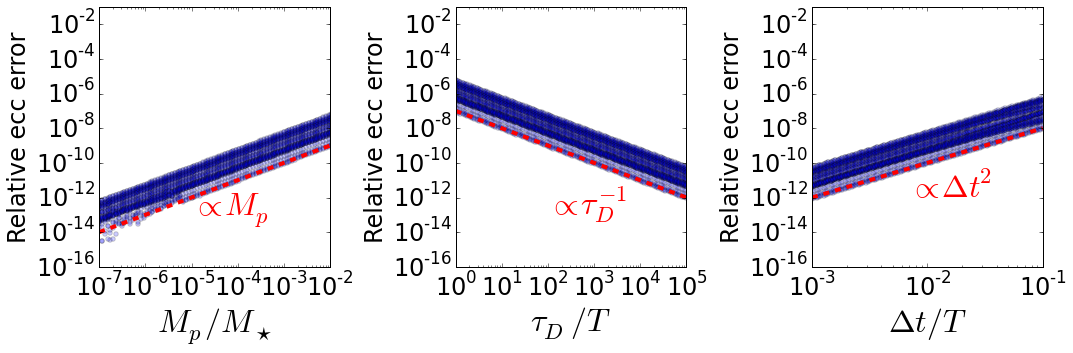

In [12]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for run in range(Nruns):
    ax1.scatter(mps, i15e1errsmp[run], alpha=0.2)
    ax2.scatter(tau_es, i15e1errstau[run], alpha=0.2)
    ax3.scatter(dts, i15e1errsdt[run], alpha=0.2)
    
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim([min(mps), 0.01])
ax1.set_ylim([1.e-16, 1.e-1])
ax1.set_xlabel(r'$M_p/M_\star$', fontsize=32)
ax1.set_ylabel(r'Relative ecc error', fontsize=24)
ax1.tick_params(labelsize=24)
mpline = [10**-14 * m/10**(-7) for m in mps]
ax1.plot(mps, mpline, 'r--', linewidth=4)
ax1.text(10**(-5), 10**(-13), r'$\propto M_p$', fontsize=32, color='red')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([min(tau_es), max(tau_es)])
ax2.set_ylim([1.e-16, 1.e-1])
ax2.set_xlabel(r'$\tau_D/T$', fontsize=32)
ax2.set_ylabel(r'Relative ecc error', fontsize=24)
ax2.tick_params(labelsize=24)
tauline = [10**-7 / tau for tau in tau_es]
ax2.plot(tau_es, tauline, 'r--', linewidth=4)
ax2.text(10**(2), 10**(-13), r'$\propto \tau_D^{-1}$', fontsize=32, color='red')

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim([min(dts), max(dts)])
ax3.set_ylim([1.e-16, 1.e-1])
ax3.set_xlabel(r'$\Delta t/T$', fontsize=32)
ax3.set_ylabel(r'Relative ecc error', fontsize=24)
ax3.tick_params(labelsize=24)
dtline = [10**-12 * (dt / 10**(-3))**2 for dt in dts]
ax3.plot(dts, dtline, 'r--', linewidth=4)
ax3.text(0.007, 10**(-12), r'$\propto \Delta t^2$', fontsize=32, color='red')

plt.tight_layout()
fig.savefig('/Users/dtamayo/Desktop/iasScaling.pdf')

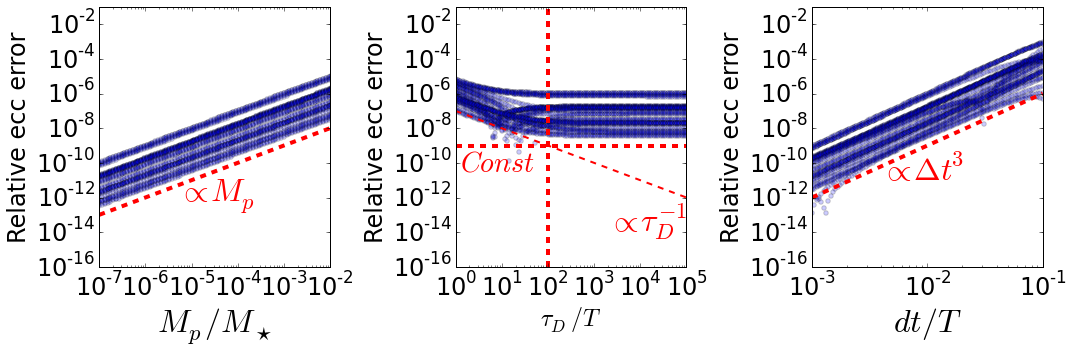

In [20]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for run in range(Nruns):
    ax1.scatter(mps, e1errsmp[run], alpha=0.2)
    ax2.scatter(tau_es, e1errstau[run], alpha=0.2)
    ax3.scatter(dts, e1errsdt[run], alpha=0.2)
    
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim([min(mps), 0.01])
ax1.set_ylim([1.e-16, 1.e-1])
ax1.set_xlabel(r'$M_p/M_\star$', fontsize=32)
ax1.set_ylabel(r'Relative ecc error', fontsize=24)
ax1.tick_params(labelsize=24)
mpline = [10**-13 * m/10**(-7) for m in mps]
ax1.plot(mps, mpline, 'r--', linewidth=4)
ax1.text(10**(-5.3), 10**(-12.2), r'$\propto M_p$', fontsize=32, color='red')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([min(tau_es), max(tau_es)])
ax2.set_ylim([1.e-16, 1.e-1])
ax2.set_xlabel(r'$\tau_D/T$', fontsize=24)
ax2.set_ylabel(r'Relative ecc error', fontsize=24)
ax2.tick_params(labelsize=24)
tauline = [10**-7 / tau for tau in tau_es]
ax2.plot(tau_es, tauline, 'r--', linewidth=2)
ax2.text(10**(3.3), 10**(-14), r'$\propto \tau_D^{-1}$', fontsize=32, color='red')
ax2.text(10**(0.1), 10**(-10.5), r'$Const$', fontsize=28, color='red')
ax2.axvline(10**2, color='red', linestyle='dashed', linewidth=4)
ax2.axhline(10**-9, color='red', linestyle='dashed', linewidth=4)
#ax2.text(10**2.2, 10**(-4), r'$E^{WH}\sim E^D$', color='red', fontsize=32)

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim([min(dts), max(dts)])
ax3.set_ylim([1.e-16, 1.e-1])
ax3.set_xlabel(r'$dt/T$', fontsize=32)
ax3.set_ylabel(r'Relative ecc error', fontsize=24)
ax3.tick_params(labelsize=24)
dtline = [10**-12 * (dt / 10**(-3))**3 for dt in dts]
ax3.plot(dts, dtline, 'r--', linewidth=4)
ax3.text(0.004, 10**(-11), r'$\propto \Delta t^3$', fontsize=32, color='red')

plt.tight_layout()
fig.savefig('/Users/dtamayo/Desktop/WHScaling.pdf')

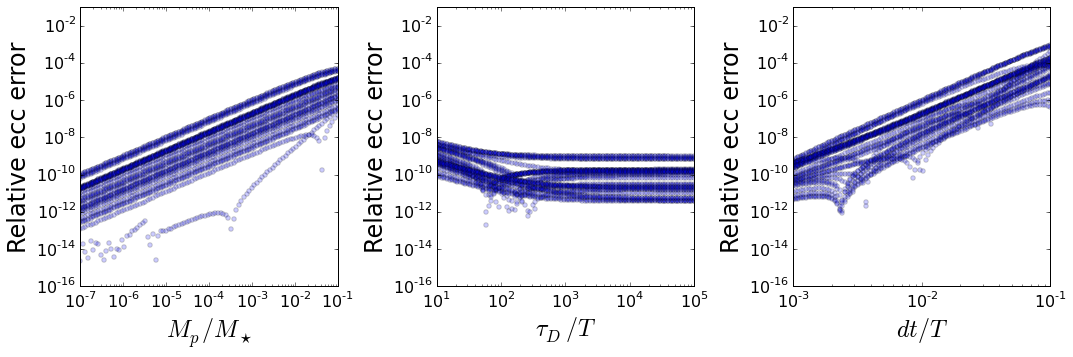

In [14]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for run in range(Nruns):
    ax1.scatter(mps, i15e1errsmp[run], alpha=0.2)
    ax2.scatter(tau_es, i15e1errstau[run], alpha=0.2)
    ax3.scatter(dts, i15e1errsdt[run], alpha=0.2)
    
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim([min(mps), max(mps)])
ax1.set_ylim([1.e-16, 1.e-1])
ax1.set_xlabel(r'$M_p/M_\star$', fontsize=24)
ax1.set_ylabel(r'Relative ecc error', fontsize=24)
ax1.tick_params(labelsize=16)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([min(tau_es), max(tau_es)])
ax2.set_ylim([1.e-16, 1.e-1])
ax2.set_xlabel(r'$\tau_D/T$', fontsize=24)
ax2.set_ylabel(r'Relative ecc error', fontsize=24)
ax2.tick_params(labelsize=16)

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim([min(dts), max(dts)])
ax3.set_ylim([1.e-16, 1.e-1])
ax3.set_xlabel(r'$dt/T$', fontsize=24)
ax3.set_ylabel(r'Relative ecc error', fontsize=24)
ax3.tick_params(labelsize=16)

plt.tight_layout()

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
plotMpScaling("ias15", ax1)
plotTauScaling("ias15", ax2)
plotDTScaling("ias15", ax3)
plt.tight_layout()

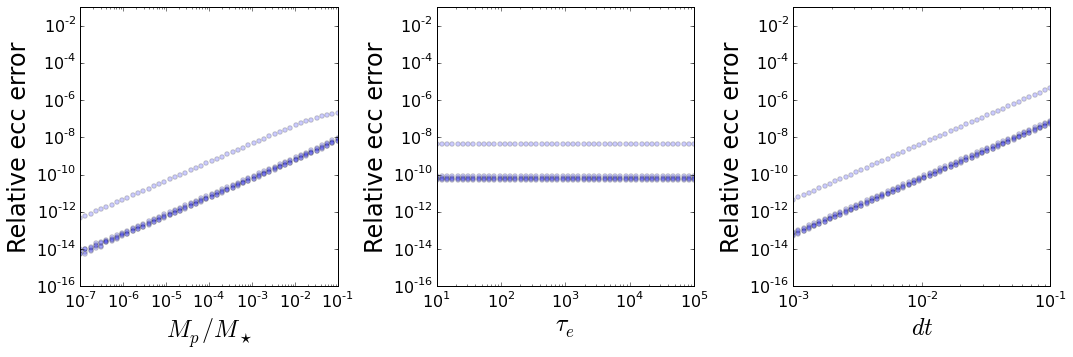

In [7]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
plotMpScaling("whfast", ax1, damping=False)
plotTauScaling("whfast", ax2, damping=False)
plotDTScaling("whfast", ax3, damping=False)
plt.tight_layout()

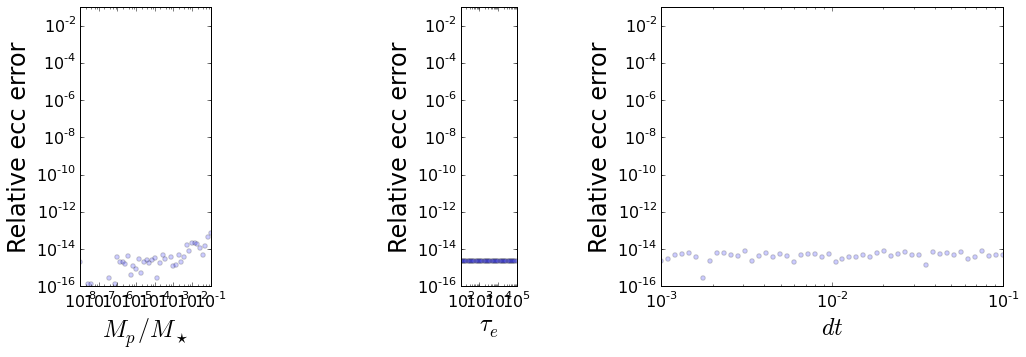

In [43]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
plotMpScaling("ias15", ax1, damping=False)
plotTauScaling("ias15", ax2, damping=False)
plotDTScaling("ias15", ax3, damping=False)
plt.tight_layout()